**Description**: Simulation for [my answer on
stackoverflow.com](https://stackoverflow.com/a/76230531/18758987) that there's an
efficient way to sample from log-probabilities or unnnormalized logits.

**Estimated runtime**: 1 min.

**TODO**: See if we can speed up the existing [LM sampling
logic](https://github.com/huggingface/transformers/blob/dee673232bdc300ced32f7c1c4cd0b9447b1478f/src/transformers/generation/utils.py#L2646-L2648).

**Package requirements**:
```
matplotlib==3.4.3
pandas==1.3.4
scipy==1.7.1
seaborn==0.11.2
tqdm==4.62.3
```

In [1]:
from __future__ import annotations
from itertools import combinations
from time import time
from typing import Union, Sequence

import numpy as np
import pandas as pd
from scipy.special import logsumexp, softmax
from scipy.stats import chisquare, chi2_contingency, trim_mean
import seaborn as sns
from tqdm.auto import tqdm

## Implementation

In [2]:
def sample_gumbels(size: Union[int, tuple[int]] = 1,
                   rng: Union[np.random.Generator, int] = None) -> np.ndarray:
    if not isinstance(rng, np.random.Generator):
        rng = np.random.default_rng(seed=rng)
    return -np.log(-np.log(rng.uniform(size=size)))


def random_choice_log_space(
    logits: np.ndarray,
    size: int = 1,
    gumbels: np.ndarray = None,
    rng: Union[np.random.Generator, int] = None,
    shuffle_gumbels: bool = True,
) -> np.ndarray:
    """
    Sample (with replacement) from a categorical distribution parametrized by logits or
    log-probabilities.

    Parameters
    ----------
    logits : np.ndarray
        the last dimension contains log-probabilities (e.g., out of a log-softmax
        function) or unnormalized logits corresponding to the categorical
        distribution(s)
    size : int, optional
        sample size, by default 1
    gumbels : np.ndarray, optional
        pre-computed Gumbel samples which will be added to `logits`, by default None
    rng : Union[np.random.Generator, int], optional
        ``np.random.Generator`` object or an integer seed, by default None
    shuffle_gumbels : bool, optional
        whether or not to shuffle `gumbels` (if provided) before taking the argmax, by
        default True. If you're not careful, setting this to False causes serial
        categorical samples to become correlated through `gumbels`, which is wrong

    Returns
    -------
    np.ndarray
        sampled indexes

    Raises
    ------
    ValueError
        if `size` is negative
    """
    if size < 1:
        raise ValueError("size must be at least 1.")
    is_gumbels_precomputed = gumbels is not None
    # Create a Generator if needed
    if not isinstance(rng, np.random.Generator):
        rng = np.random.default_rng(seed=rng)
    if not is_gumbels_precomputed:
        # Independently sample as many Gumbels as needed. During addition, they'll be
        # broadcasted
        _gumbels_shape = (size,) + logits.shape if size > 1 else logits.shape
        gumbels = sample_gumbels(size=_gumbels_shape)
    if is_gumbels_precomputed and shuffle_gumbels:
        # Shuffling is unnecessary if the Gumbels were just randomly sampled.
        # It's necessary if the Gumbels were pre-computed and plan to be re-used.
        gumbels_original_shape = gumbels.shape
        if len(gumbels_original_shape) > 1:
            gumbels = gumbels.ravel()
        # gumbels is 1-D. For some reason, choice is faster than shuffle and permuted
        gumbels = rng.choice(gumbels, size=len(gumbels), replace=False, shuffle=True)
        if len(gumbels_original_shape) > 1:
            gumbels = gumbels.reshape(gumbels_original_shape)
    gumbels_rescaled: np.ndarray = logits + gumbels
    return gumbels_rescaled.argmax(axis=-1)

## Statistical check

In [3]:
_probs = np.array([0.1, 0.2, 0.3, 0.4])

log_probs = np.log(_probs)
logits = np.log(_probs) + logsumexp(_probs, axis=-1)
# You start out with access to log_probs or logits

num_categories = len(_probs)

sample_size = 500_000
seed = 123
rng = np.random.default_rng(seed)


# helper function
def empirical_distr(discrete_samples):
    return (pd.Series(discrete_samples)
            .value_counts(normalize=True)
            .sort_index()
            .to_numpy())


# np.random.choice (select one at a time) AKA vanilla sampling
def random_choice_log_space_vanilla(logits, size, rng=None):
    probs = softmax(logits, axis=-1)
    if not isinstance(rng, np.random.Generator):
        rng = np.random.default_rng(seed=rng)
    return rng.choice(len(probs), p=probs, size=size, replace=True)


samples = random_choice_log_space_vanilla(logits, size=sample_size, rng=rng)
distr_vanilla = empirical_distr(samples)


# random_choice_log_space for log-probabilities input
samples = random_choice_log_space(log_probs, size=sample_size, rng=rng)
distr_log_probs = empirical_distr(samples)


# random_choice_log_space for logits input
samples = random_choice_log_space(logits, size=sample_size, rng=rng)
distr_logits = empirical_distr(samples)

In [4]:
pd.DataFrame({'rel error (vanilla)': (distr_vanilla - _probs)/_probs,
              'rel error (log-probs)': (distr_log_probs - _probs)/_probs,
              'rel error (logits)': (distr_logits - _probs)/_probs},
              index=pd.Index(range(len(_probs)), name='category'))

# print(pd.DataFrame({'rel error (vanilla)': (distr_vanilla - _probs)/_probs,
#                     'rel error (log-probs)': (distr_log_probs - _probs)/_probs,
#                     'rel error (logits)': (distr_logits - _probs)/_probs},
#                     index=pd.Index(range(len(_probs)), name='category')))

,rel error (vanilla),rel error (log-probs),rel error (logits)
category,,,
0,-0.004760,-0.00456,0.00180
1,0.000170,0.00118,-0.00005
2,0.002773,-0.00004,-0.00086
3,-0.000975,0.00058,0.00022


Even at this super high sample size, the p-value for a [chi-squared
test](https://en.wikipedia.org/wiki/Chi-squared_test) is nearly 1 for all methods.

In [5]:
print(chisquare(f_obs=distr_vanilla,   f_exp=_probs).pvalue)
print(chisquare(f_obs=distr_log_probs, f_exp=_probs).pvalue)
print(chisquare(f_obs=distr_logits,    f_exp=_probs).pvalue)

0.999999997062783
0.9999999989531836
0.9999999998868266


## Precompute and shuffle Gumbels

### Statistical check

First, let's demonstrate that not shuffling pre-computed Gumbels causes samples across
draws to become dependent. This fact can be mathematically proven, but it's easier for
me to just simulate. It's trivial in the case where logits are constant across draws
(the exact same category will be selected!). It may seem less trivial in the case where
logits are different across draws, like during LLM sampling.

In [6]:
# ty: https://stackoverflow.com/a/39266194/18758987
def cramers_corrected_stat(confusion_matrix: np.ndarray):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    correction = confusion_matrix.shape[0] != 2
    chi2 = chi2_contingency(confusion_matrix, correction=correction)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min(kcorr-1, rcorr-1))


def sample_across(
    num_draws: int,
    gumbels: np.ndarray,
    shuffle_gumbels: bool,
    rng: Union[np.random.Generator, int]=None
) -> tuple[np.ndarray, np.ndarray]:
    # Create a Generator if needed
    if not isinstance(rng, np.random.Generator):
        rng = np.random.default_rng(seed=rng)

    samples_all = []
    # Generate logits independently
    logits = rng.normal(size=(num_draws, num_categories))
    for i in range(num_draws):
        samples_all.append(random_choice_log_space(logits[i], size=sample_size,
                                                   gumbels=gumbels,
                                                   rng=rng,
                                                   shuffle_gumbels=shuffle_gumbels))
    return np.array(samples_all), logits


def correlation_heatmap(num_categories: int, sample_size: int, shuffle_gumbels: bool,
                        num_draws: int=20, rng: Union[np.random.Generator, int]=None):
    if sample_size <= 1:
        raise ValueError( 'To estimate correlations, need sample_size > 1. '
                         f'Got {sample_size}.')

    # Create a Generator if needed
    if not isinstance(rng, np.random.Generator):
        rng = np.random.default_rng(seed=rng)

    # Precompute Gumbels
    gumbels = sample_gumbels(size=(sample_size, num_categories), rng=rng)

    # Samples
    samples_all, _ = sample_across(num_draws, gumbels, shuffle_gumbels, rng=rng)

    # Correlation matrix. We'll have to populate it 1-by-1. I'm not gonna worry about
    # vectorizing cramers_corrected_stat
    correlation_matrix = np.empty((num_draws, num_draws))
    correlation_matrix[:] = np.NaN  # I want errors if anything is unfilled
    np.fill_diagonal(correlation_matrix, 1)

    for i, j in tqdm(combinations(range(num_draws), 2),
                     total=int(num_draws*(num_draws-1)/2),
                     desc='Estimating correlations'):
        if not np.isnan(correlation_matrix[i,j]):
            continue
        confusion_matrix = pd.crosstab(samples_all[i], samples_all[j]).to_numpy()
        correlation = cramers_corrected_stat(confusion_matrix)
        correlation_matrix[i,j] = correlation
        correlation_matrix[j,i] = correlation

    assert not np.any(np.isnan(correlation_matrix)), 'Ruh roh, some are NaN!'

    # Add a bit so that we can filter out zeros later
    correlation_matrix += np.finfo(float).eps

    # Summary stats for correlation, dropping diagonal since they're trivially all 1s
    # and duplicate correlations b/c it's symmetric
    print('Summary of correlations')
    tril = np.tril(correlation_matrix, k=-1)
    tril[-1, -1] = 0
    correlations_flat = tril.ravel()
    # tril filled the upper triangle with 0s. now we filter them out
    correlations_flat = correlations_flat[correlations_flat != 0]
    print(pd.Series(correlations_flat).describe())

    # Heatmap
    sns.heatmap(correlation_matrix)

If we don't shuffle, expect correlations > 0 everywhere.

Estimating correlations:   0%|          | 0/190 [00:00<?, ?it/s]

Summary of correlations
count    190.000000
mean       0.564933
std        0.245432
min        0.080868
25%        0.360804
50%        0.584648
75%        0.754100
max        1.000000
dtype: float64


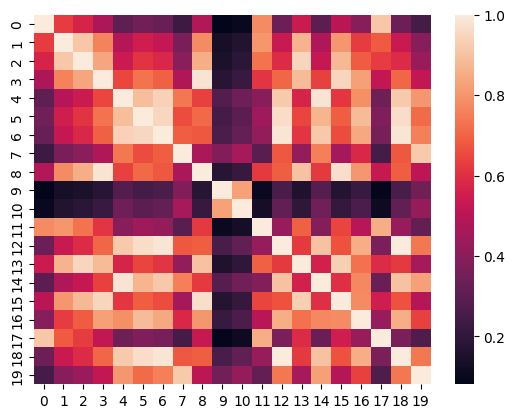

In [7]:
num_categories = 2
sample_size = 1_000
num_draws = 20
seed = 42
shuffle_gumbels = False

correlation_heatmap(num_categories, sample_size, shuffle_gumbels=shuffle_gumbels,
                    num_draws=num_draws, rng=seed)

If we do shuffle, expect correlations approximately 0 everywhere (except diagonal ofc).

Estimating correlations:   0%|          | 0/190 [00:00<?, ?it/s]

Summary of correlations
count    1.900000e+02
mean     1.066691e-02
std      1.836102e-02
min      2.220446e-16
25%      2.220446e-16
50%      2.220446e-16
75%      1.813771e-02
max      9.315776e-02
dtype: float64


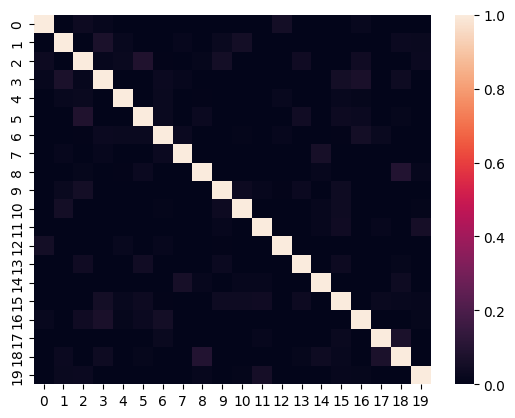

In [8]:
num_categories = 2
sample_size = 1_000
num_draws = 20
seed = 42
shuffle_gumbels = True

correlation_heatmap(num_categories, sample_size, shuffle_gumbels=shuffle_gumbels,
                    num_draws=num_draws, rng=seed)

Next, let's verify that the empirical distribution is good.

In [9]:
num_categories = 4
sample_size = 100_000
num_draws = 20
seed = 42
shuffle_gumbels = True

gumbels = sample_gumbels(size=(sample_size, num_categories), rng=seed)
samples_all, logits = sample_across(num_draws, gumbels, shuffle_gumbels=True, rng=seed)

prob_distrs = softmax(logits, axis=1)
empirical_distrs = np.array([empirical_distr(samples) for samples in samples_all])
print('Avg relative error:', np.mean((prob_distrs - empirical_distrs) / prob_distrs))

Avg relative error: 0.00012982827302159282


Good

### Computational check

Now for a computational comparison, not including the time to generate Gumbels.

In [10]:
def time_func(func, *args, num_replications: int=50, **kwargs) -> list[float]:
    '''
    Returns a list, `times`, where `times[i]` is the time it took to run
    `func(*args, **kwargs)` at replication `i` of `num_replications`.
    '''
    times = []
    for _ in range(num_replications):
        time_start = time()
        _ = func(*args, **kwargs)
        time_end = time()
        times.append(time_end - time_start)
    return times


def plot_sampling_times(category_sizes: Sequence[int], sample_size: int,
                        num_replications: int=100, trim_frac: float=0.1):
    times_vanilla = []
    times_gumbel = []
    times_gumbel_pre = []
    for size in category_sizes:
        logits: np.ndarray = np.random.normal(size=size)
        gumbels = sample_gumbels(size=logits.shape)
        times_vanilla.append(time_func(random_choice_log_space_vanilla,
                                       logits,
                                       size=sample_size,
                                       num_replications=num_replications))
        times_gumbel.append(time_func(random_choice_log_space,
                                      logits,
                                      size=sample_size,
                                      num_replications=num_replications))
        times_gumbel_pre.append(time_func(random_choice_log_space,
                                          logits,
                                          size=sample_size,
                                          gumbels=gumbels,
                                          num_replications=num_replications))
    # Only look at middle 80% of times
    (pd.DataFrame({'vanilla': trim_mean(times_vanilla, trim_frac, axis=1),
                   'Gumbel-max trick': trim_mean(times_gumbel, trim_frac, axis=1),
                   'Gumbel-max trick (pre-computed)': trim_mean(times_gumbel_pre,
                                                                trim_frac, axis=1)},
                  index=pd.Index(category_sizes, name='# categories'))
     .plot.bar(title=f'Categorical sampling (sample size = {sample_size})',
               figsize=(7,4),
               ylabel='mean wall-clock time (sec)'));

In [11]:
logits = np.random.normal(size=50_257)  # GPT-2 vocab size
gumbels = np.random.gumbel(size=logits.shape)

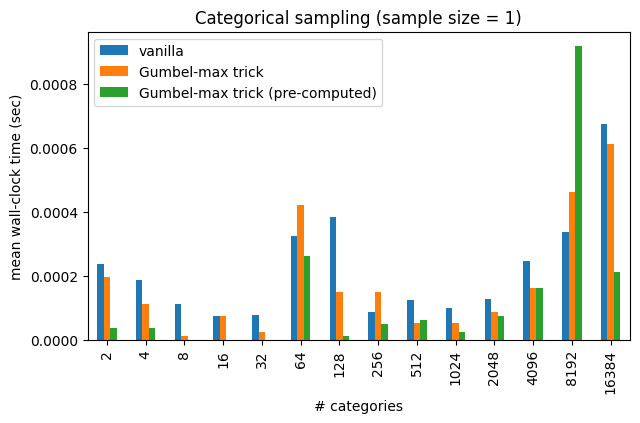

In [12]:
category_sizes = np.power(2, np.arange(1, 14+1))
sample_size = 1
num_replications = 100

plot_sampling_times(category_sizes, sample_size, num_replications=num_replications)

There's usually a significant speedup on small categoricals. The comparison becomes less
stable for larger ones. Let's see what it looks like there. 

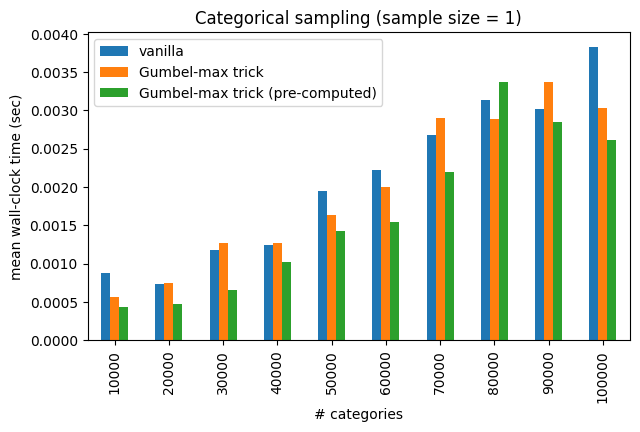

In [13]:
category_sizes = np.linspace(10_000, 100_000, num=10).astype(int)
sample_size = 1
num_replications = 100

plot_sampling_times(category_sizes, sample_size, num_replications=num_replications)

Not a significant speedup using pre-computed Gumbel-max trick vs vanilla categorical
sampling in this range. Interestingly, the bottleneck is in shuffling Gumbels. And the
particular implementation of shuffling matters: `choice` seems to be faster than the
in-place `shuffle` method, which is surprising to me.

I'm still curious to see whether there's any speedup on torch + GPU. I think the softmax
used in vanilla sampling would be faster.